In [1]:
import gym
import numpy as np
from numpy import random

c:\Users\Jonathan\AppData\Local\Programs\Python\Python310\lib\site-packages\gym\wrappers\monitoring\video_recorder.py:9: DeprecationWarning: The distutils package is deprecated and slated for removal in Python 3.12. Use setuptools or check PEP 632 for potential alternatives
  import distutils.spawn


In [2]:
env = gym.make('MountainCarContinuous-v0')

In [4]:
env.observation_space

Box([-1.2  -0.07], [0.6  0.07], (2,), float32)

In [3]:
print(env.action_space)
env.observation_space

Box(-1.0, 1.0, (1,), float32)


Box([-1.2  -0.07], [0.6  0.07], (2,), float32)

In [5]:
state = env.reset()
state

array([-0.49495122,  0.        ], dtype=float32)

In [6]:
# Create a discrete state space
location_range = (-1.2, 0.6)
location_step = 0.01
velocity_range = (-0.07, 0.07)
velocity_step = 0.01

locations = np.arange(location_range[0], location_range[1]+location_step, step = location_step)
velocities = np.arange(velocity_range[0], velocity_range[1]+velocity_step, step = velocity_step)

grid = np.array(np.meshgrid(locations, velocities))
grid = grid.T.reshape(-1, 2)

In [13]:
velocities

array([-0.07, -0.06, -0.05, -0.04, -0.03, -0.02, -0.01,  0.  ,  0.01,
        0.02,  0.03,  0.04,  0.05,  0.06,  0.07,  0.08])

In [8]:
# Experiments
print(state)

nearest_location = locations[np.argmin(np.abs(locations - state[0]))]
nearest_velocity = velocities[np.argmin(np.abs(velocities - state[1]))]

nearest_row = np.array([nearest_location, nearest_velocity])
print(nearest_row)

mask = grid == nearest_row
mask = [np.all(row) for row in mask]

state_number = np.where(mask)
print(state_number)

[-0.49495122  0.        ]
[-0.49  0.  ]
(array([1143], dtype=int64),)


In [10]:
def get_state_number(state, grid, locations, velocities):
    nearest_location = locations[np.argmin(np.abs(locations - state[0]))]
    nearest_velocity = velocities[np.argmin(np.abs(velocities - state[1]))]
    nearest_row = np.array([nearest_location, nearest_velocity])
    mask = grid == nearest_row
    mask = [np.all(row) for row in mask]    

    state_number = np.where(mask)

    return state_number


In [9]:
class QAgent:
    def __init__(self, env, state, alpha, gamma, q_table):
        self.env = env
        self.state = state
        self.alpha = alpha
        self.gamma = gamma
        self.q_table = q_table
        self.total_reward = 0
        self.done = False

    def get_action(self, state):    
        return np.argmax(self.q_table[state])

    def update_q_table(self, state_number, next_state_number, action_number, reward):

        old_value = self.q_table[state_number, action_number]
        next_max = np.max(self.q_table[next_state_number])

        new_value = (1 - self.alpha) * old_value + self.alpha * (reward + self.gamma * next_max)
        self.q_table[state_number, action_number] = new_value

In [12]:
discrete_actions = np.array([-1, 1], dtype='float32')
q_table = np.zeros((len(grid), len(discrete_actions)))
state=env.reset()

agent = QAgent(env=env, state=state, alpha=0.1, gamma=0.5, q_table=q_table)


In [13]:
# Train agent
max_step = 999

epsilon_max = 0.2
epsilon_min = 0.001
epsilon_delta = epsilon_max-epsilon_min

episodes = 300

steps_taken = np.zeros(shape = (episodes), dtype='int')

for i in range(episodes):

    print("Episode: " + str(i))

    state = env.reset()
    done = False
    state_number = get_state_number(state,grid,locations,velocities)
    current_epsilon = epsilon_max - (epsilon_delta * i / episodes)
    step_count = 0

    while not done:

        step_count += 1

        if current_epsilon > random.rand():
            action_number = random.randint(0, len(discrete_actions))
            action = discrete_actions[action_number]
        else:
            action_number = agent.get_action(state_number)
            action = discrete_actions[action_number]

        next_state, reward, done, info = env.step([action])

        next_state_number = get_state_number(next_state,grid,locations,velocities)

        agent.update_q_table(state_number=state_number, next_state_number=next_state_number, action_number=action_number, reward=reward)

        state_number = next_state_number

        if reward > 0:
            print("Positive reward found at step " + str(step_count) + " : " + str(reward))
        
        # if (step_count % 100 == 0) | (step_count == 999): print("Step: " + str(step_count))

        if (done == True) | (step_count == max_step):
            steps_taken[i] = step_count


Episode: 0
Episode: 1
Episode: 2
Episode: 3
Episode: 4
Episode: 5
Episode: 6
Episode: 7
Episode: 8
Episode: 9
Episode: 10
Episode: 11
Episode: 12
Episode: 13
Episode: 14
Episode: 15
Positive reward found at step 888 : 99.9
Episode: 16
Episode: 17
Episode: 18
Positive reward found at step 677 : 99.9
Episode: 19
Episode: 20
Episode: 21
Positive reward found at step 754 : 99.9
Episode: 22
Episode: 23
Episode: 24
Episode: 25
Episode: 26
Positive reward found at step 476 : 99.9
Episode: 27
Episode: 28
Episode: 29
Positive reward found at step 639 : 99.9
Episode: 30
Episode: 31
Episode: 32
Episode: 33
Positive reward found at step 990 : 99.9
Episode: 34
Episode: 35
Positive reward found at step 492 : 99.9
Episode: 36
Positive reward found at step 505 : 99.9
Episode: 37
Episode: 38
Episode: 39
Positive reward found at step 933 : 99.9
Episode: 40
Positive reward found at step 665 : 99.9
Episode: 41
Episode: 42
Episode: 43
Episode: 44
Positive reward found at step 428 : 99.9
Episode: 45
Episode

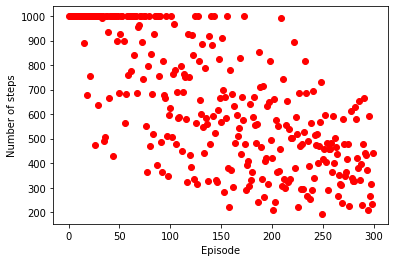

In [14]:
# Plots
import matplotlib.pyplot as plt

y_axis = [*range(len(steps_taken))]

plt.plot(y_axis, steps_taken, 'ro')

plt.xlabel("Episode")
plt.ylabel("Number of steps")

plt.show()

In [ ]:
agent.q_table[agent.q_table > 0]

In [ ]:
next_state_number

action_number = agent.get_action(state_number)
action = discrete_actions[action_number]

action


In [ ]:
agent.q_table[next_state_number]